## **Dataset and Problem Description**

The dataset used in this project is the **MBA Admission Dataset, Class of 2025**, which is a classification problem. The dataset contains several instances with 9 features, and the target variable is **admission status** (Admit, Waitlist, or Deny). The dataset is relatively balanced but may contain bias due to factors such as gender, race, and academic background, which can affect the fairness of the admissions process.

### **Features**
This dataset includes various attributes of the applicants, such as:

- **application_id**: Unique identifier for each application
- **gender**: Applicant's gender (Male, Female)
- **international**: Whether the applicant is an international student (TRUE/FALSE)
- **gpa**: Grade Point Average (on a 4.0 scale)
- **major**: Undergraduate major (Business, STEM, Humanities)
- **race**: Racial background of the applicant (e.g., White, Black, Asian, Hispanic, Other / null: international student)
- **gmat**: GMAT score (out of 800)
- **work_exp**: Number of years of work experience
- **work_industry**: Industry of previous work experience (e.g., Consulting, Finance, Technology, etc.)
- **admission**: Admission status (Admit, Waitlist, Deny)

### **Why this dataset?**

The **MBA Admission Dataset** and the **Rotterdam system** both share concerns regarding **fairness** and **explainability**, but in different contexts. While the Rotterdam system is punitive, as it denies essential benefits, the MBA admission process is not punitive, though it still has a significant impact on candidates' future professional opportunities. Both systems, however, can be affected by biases such as **gender**, **ethnicity**, and other demographic factors, which may influence the decision-making process in unjust ways.

Just as the Rotterdam system faced criticism for lack of fairness and transparency in its decisions, the MBA admissions process also raises similar concerns. Factors like **gender**, **race**, **academic performance**, and **work experience** can inadvertently introduce bias, potentially leading to unfair outcomes for certain groups. Therefore, **explainability** is crucial in both cases. For the MBA admission process, it is essential to ensure that the decisions are transparent and that the criteria used are well-understood by all stakeholders. This way, we can ensure that admissions are based on merit, not influenced by bias, and that the process is just, transparent, and accountable.

In both cases, addressing fairness and improving explainability will lead to better decision-making, ensuring that individuals are not unfairly excluded or advantaged based on arbitrary or discriminatory factors.

## **Prerequisites**

To run this notebook, you need to have the following libraries installed:
- `python` (3.6+)
- `pandas` (1.1+)
- `matplotlib` (3.3+)
- `seaborn` (0.11+)
- `scikit-learn` (0.24+)
- `shap` (0.39+)

You can install the required libraries using `pip` as shown below:

```bash
pip install pandas matplotlib scikit-learn shap
```


In [32]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.inspection import partial_dependence, PartialDependenceDisplay
from sklearn.inspection import permutation_importance
import shap
shap.initjs()

df = pd.read_csv("MBA.csv")
df.head()

,application_id,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,2,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,NaN
2,3,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,4,Male,False,3.47,STEM,Black,690.0,6.0,Technology,NaN
4,5,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,NaN


### **Feature Engineering and Preprocessing**


In [33]:
df['gender'].unique()

array(['Female', 'Male'], dtype=object)

#### **Remove Unnecessary Columns**
We will remove the `application_id` column, as it serves as a unique identifier and does not contribute meaningful information for the model's predictions.


In [34]:
del(df['application_id'])

#### **Fill Missing Values**

The dataset's target variable, `admission`, contains missing values, which are interpreted as cases of no admission. We will replace these missing values with the string `No admit` to indicate that the applicant was not admitted.

In [35]:
df.admission = df.admission.fillna('No admit')
df.head()

,gender,international,gpa,major,race,gmat,work_exp,work_industry,admission
0,Female,False,3.30,Business,Asian,620.0,3.0,Financial Services,Admit
1,Male,False,3.28,Humanities,Black,680.0,5.0,Investment Management,No admit
2,Female,True,3.30,Business,NaN,710.0,5.0,Technology,Admit
3,Male,False,3.47,STEM,Black,690.0,6.0,Technology,No admit
4,Male,False,3.35,STEM,Hispanic,590.0,5.0,Consulting,No admit


We observed that the `race` feature has missing values when the `international` feature is set to `TRUE`, indicating that the applicant is an international student. To address this, we will replace the missing values in the `race` feature with the string `International`. Additionally, we will remove the `international` feature, as it is no longer relevant for the model.

In [36]:
df[df.international]["race"].unique()

array([nan], dtype=object)

In [37]:
df.race = df.race.fillna('International')
del(df['international'])

Now, we treated all missing values in the dataset.

In [38]:
df.isnull().sum().sum()

0

#### **Encoding Categorical Features**

We will encode the categorical features using mapping dictionaries and LabelEncoder from scikit-learn. The categorical features include `gender`, `major`, `race`, `work_industry`, and the target variable `admission`.

We created `X_display` and `y_display` to preserve the original, unmodified data for analysis, even after label encoding is applied. Once we encode the features and target variable, we will use the encoded versions in `X` and `y` for modeling. The goal of keeping `X_display` and `y_display` is to retain access to the raw data for visualization and comparison before applying any transformations.

In [39]:
X_display = df.drop('admission', axis=1)
y_display = df['admission']

Mapping the column `admission` to integers:

In [40]:
admission_mapping = {'Admit': 1, 'Waitlist': 0, 'No admit': 0}
df['admission'] = df.admission.map(admission_mapping)

Here we calculate the average admission rate for each racial group in the dataset. By grouping the data based on the `race` feature and then calculating the mean of the `admission` variable, it shows the proportion of admissions (e.g., the percentage of admitted students) for each race. This can help identify any patterns or disparities in admissions across different racial groups.


In [41]:
df.groupby("race")["admission"].mean()

race
Asian            0.165650
Black            0.087336
Hispanic         0.104027
International    0.150923
Other            0.194093
White            0.167582
Name: admission, dtype: float64

We will convert the `gender` column to a binary format and use `LabelEncoder` to encode the categorical columns `major`, `race`, and `work_industry`.

In [42]:
df.gender = (df.gender == 'Female').astype(int)

for col in df.select_dtypes(include=['object']).columns: # major race and work_industry
    df[col] = LabelEncoder().fit_transform(df[col])


In [43]:
df.head()

,gender,gpa,major,race,gmat,work_exp,work_industry,admission
0,1,3.30,0,0,620.0,3.0,3,1
1,0,3.28,1,1,680.0,5.0,6,0
2,1,3.30,0,3,710.0,5.0,13,1
3,0,3.47,2,1,690.0,6.0,13,0
4,0,3.35,2,2,590.0,5.0,1,0


Here we will visualize the correlation matrix of the dataset to understand the relationships between different features. This can help identify any patterns or dependencies between the features.

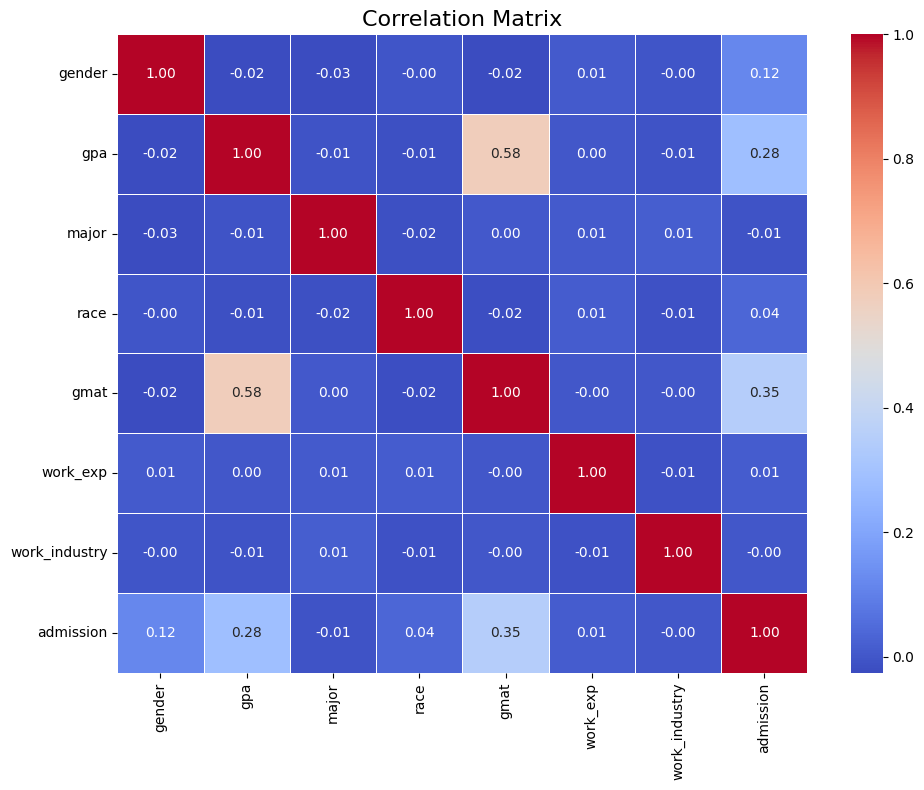

In [ ]:
corr_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation Matrix', fontsize=16)
plt.tight_layout()
plt.show()

Now, we will analyze the correlation between the features and the target variable `admission` to understand how each feature is related to the target.

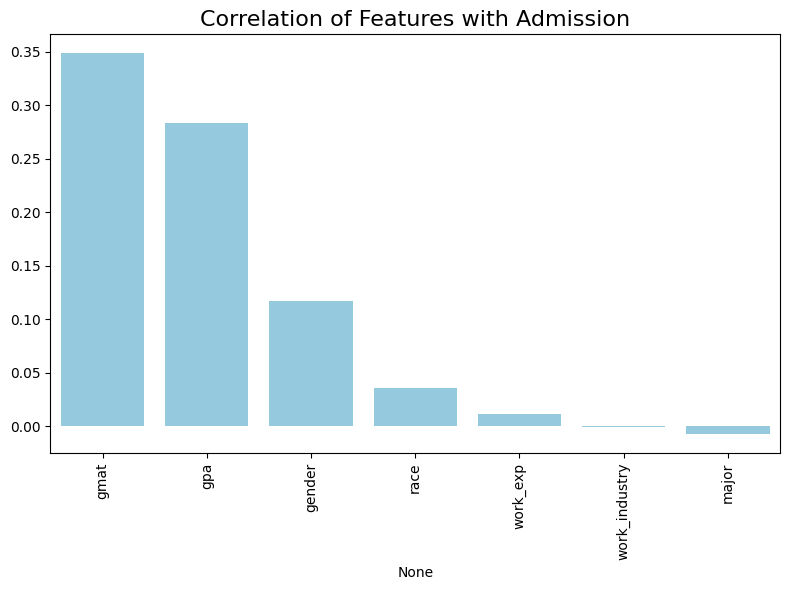

In [59]:
corr_with_admission = corr_matrix['admission'].sort_values(ascending=False)
corr_with_admission = corr_with_admission.drop('admission')

plt.figure(figsize=(8, 6))
sns.barplot(x=corr_with_admission.index, y=corr_with_admission.values, color='skyblue')
plt.xticks(rotation=90)
plt.title('Correlation of Features with Admission', fontsize=16)
plt.tight_layout()
plt.show()

### **Modeling**

Now that we have preprocessed the data, we can proceed with building a machine learning model to predict the admission status based on the applicant's features. For this, we will use the **Gradient Boosting Machine (GBM)** model, the same algorithm used in the Rotterdam case, to ensure robust predictions. The following steps outline the process we'll follow:

#### **Splitting the Data**
We will split the data into training and testing sets using a 80-20 split. This will allow us to train the model on a subset of the data and evaluate its performance on unseen data.


In [45]:
X = df.drop('admission', axis=1)
y = df['admission']

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Now, we will train the **Gradient Boosting Machine (GBM)** model on the training data. The model will learn the relationships between the applicant's features and their admission status.



In [47]:
gbc = GradientBoostingClassifier()
gbc.fit(X_train, y_train)

GradientBoostingClassifier()

#### **Explainability and Feature Importance**

To enhance **explainability**, we will then extract the feature importances from the trained model, which tells us how much each feature contributes to the model's predictions. By plotting a bar chart of these feature importances, we can visualize which features have the most influence on predicting admission, such as GMAT score, GPA, or work experience. This step helps provide transparency into the model's decision-making process, allowing us to better understand and explain why certain predictions are made.

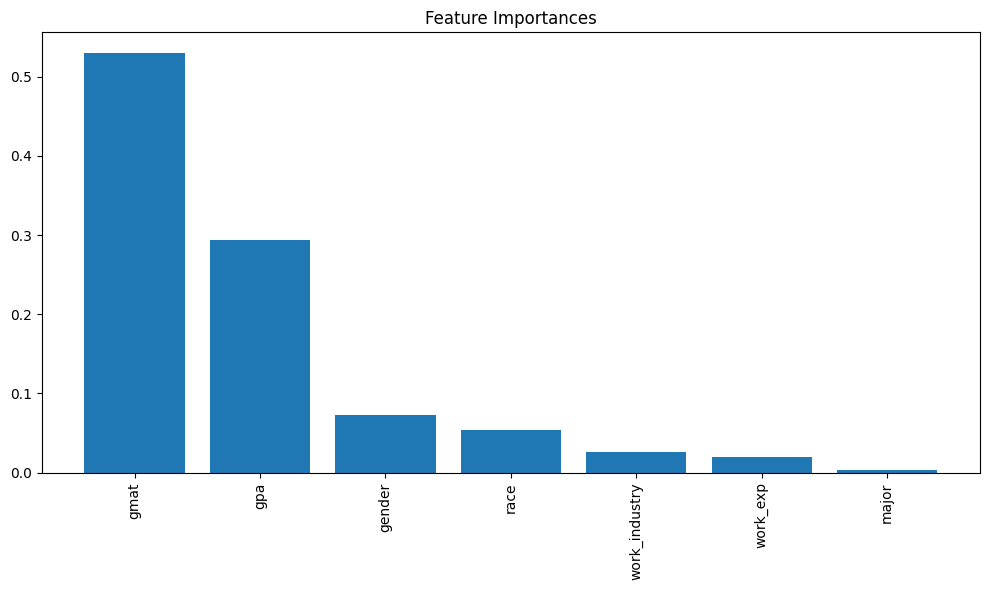

In [48]:
importances = gbc.feature_importances_

# Plot feature importances
feature_importance = sorted(zip(importances, X_train.columns), reverse=True)

plt.figure(figsize=(10, 6))
plt.bar(range(len(importances)), [imp for imp, _ in feature_importance])
plt.xticks(range(len(importances)), [name for _, name in feature_importance], rotation=90)
plt.title("Feature Importances")
plt.tight_layout()
plt.show()

In [49]:

# # Create partial dependence plot
# fig, ax = plt.subplots(figsize=(10, 6))
# PartialDependenceDisplay.from_estimator(gbc, X, features=['feature_name'])
# # plt.show()


In [50]:
r = permutation_importance(gbc, X_test, y_test, n_repeats=30, random_state=0)

In [51]:
explainer = shap.TreeExplainer(gbc)
shap_values = explainer.shap_values(X)

In [52]:
shap.force_plot(explainer.expected_value, shap_values[0, :], X_display.iloc[0, :])

In [53]:
shap.force_plot(explainer.expected_value, shap_values[:1000, :], X_display.iloc[:1000, :])

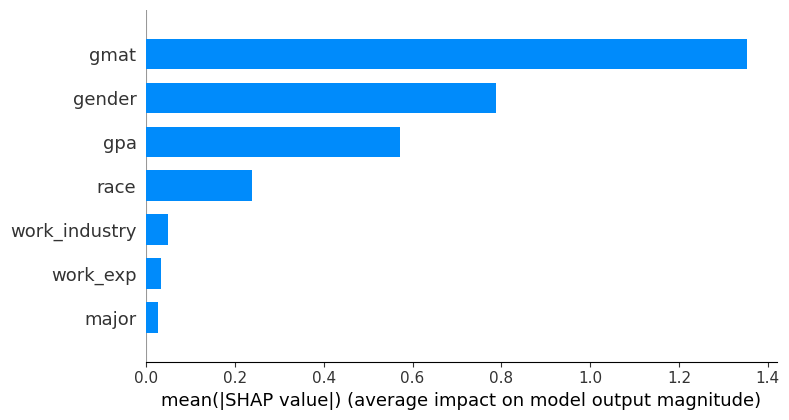

In [54]:
shap.summary_plot(shap_values, X_display, plot_type="bar")

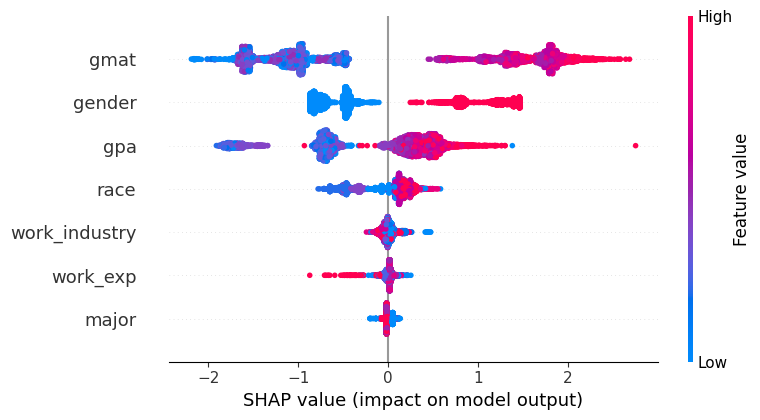

In [55]:
shap.summary_plot(shap_values, X)

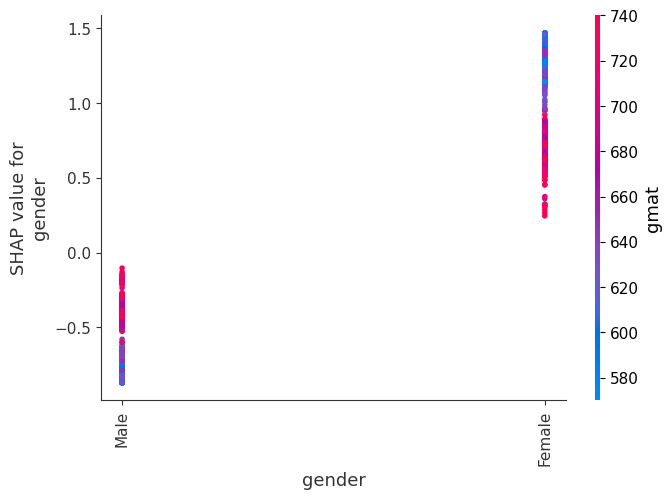

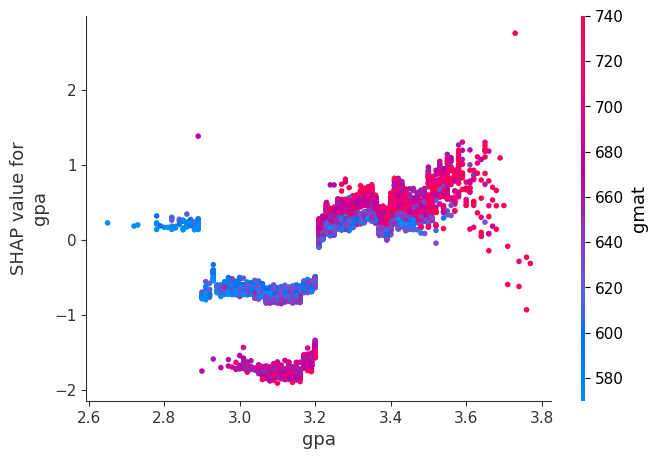

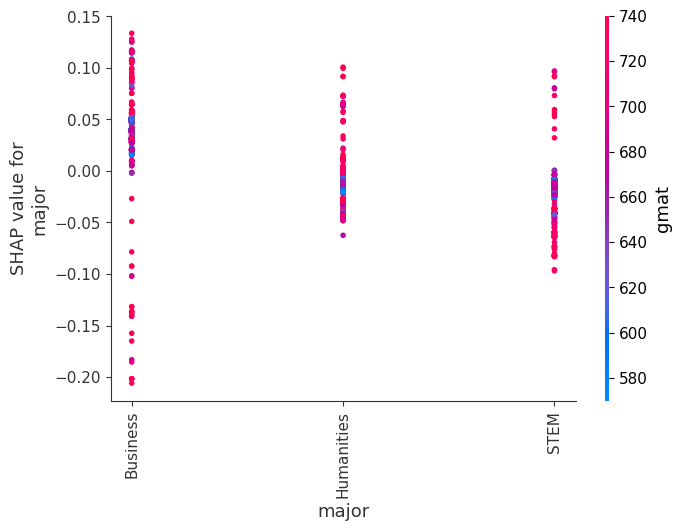

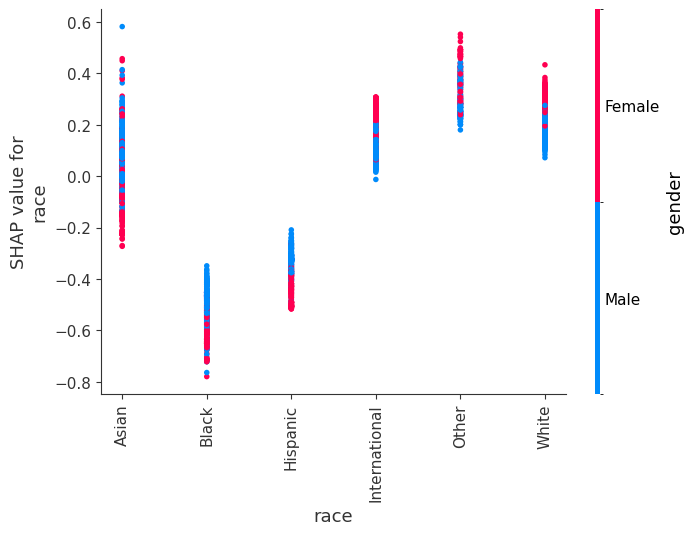

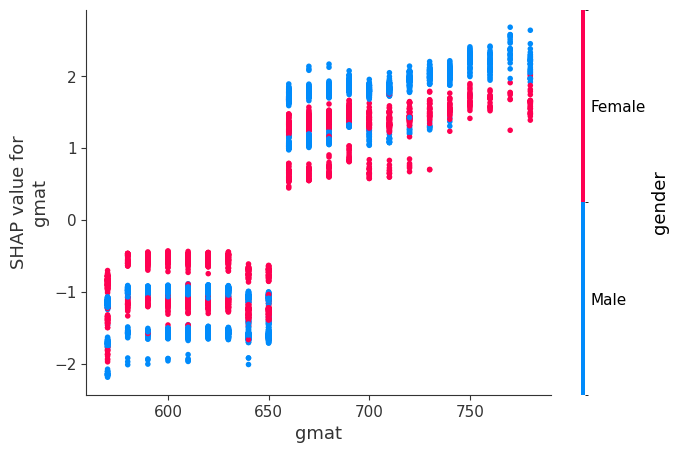

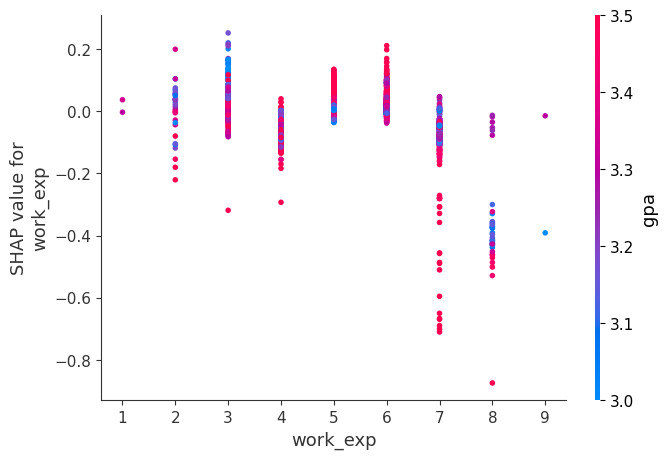

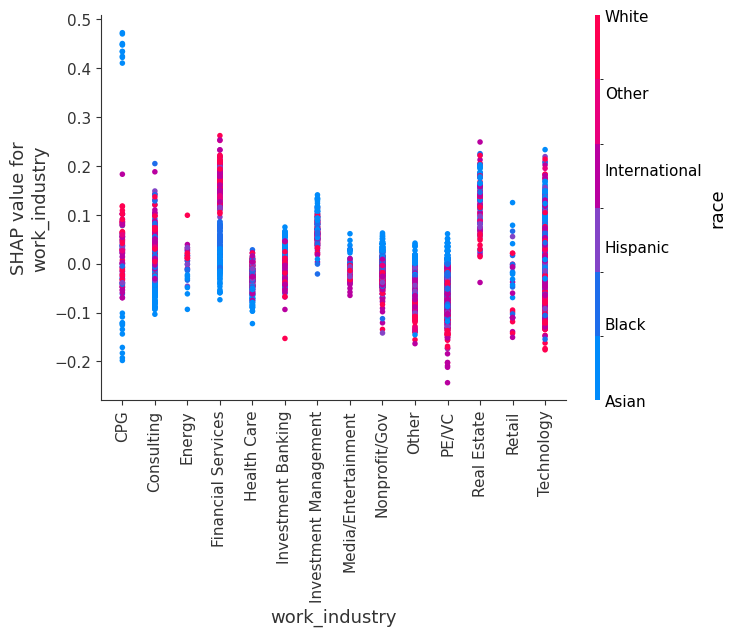

In [56]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X, display_features=X_display)